#  <font color=green>Credit Card Fraud Detection</font>

## Importing the Libraries  

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

## Data Importing

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
print(data.head(10))

   Time        V1        V2        V3  ...         V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...    0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ...   -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ...   -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...    0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...    0.219422  0.215153   69.99      0
5   2.0 -0.425966  0.960523  1.141109  ...    0.253844  0.081080    3.67      0
6   4.0  1.229658  0.141004  0.045371  ...    0.034507  0.005168    4.99      0
7   7.0 -0.644269  1.417964  1.074380  ...   -1.206921 -1.085339   40.80      0
8   7.0 -0.894286  0.286157 -0.113192  ...    0.011747  0.142404   93.20      0
9   9.0 -0.338262  1.119593  1.044367  ...    0.246219  0.083076    3.68      0

[10 rows x 31 columns]


In [4]:
print(data.tail(10))

            Time         V1         V2  ...         V28  Amount  Class
284797  172782.0  -0.241923   0.712247  ...    0.081265    5.49      0
284798  172782.0   0.219529   0.881246  ...    0.215243   24.05      0
284799  172783.0  -1.775135  -0.004235  ...    0.130308   79.99      0
284800  172784.0   2.039560  -0.175233  ...   -0.075071    2.68      0
284801  172785.0   0.120316   0.931005  ...    0.068803    2.69      0
284802  172786.0 -11.881118  10.071785  ...    0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ...   -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ...   -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...    0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...    0.013649  217.00      0

[10 rows x 31 columns]


## Exploring the Dataset

In [5]:
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
data.shape

(284807, 31)

In [7]:
# random_state helps assure that you always get the same output when you split the data
# this helps create reproducible results and it does not actually matter what the number is
# frac is percentage of the data that will be returned
data = data.sample(frac = 0.2, random_state = 1)
print(data.shape)

(56961, 31)


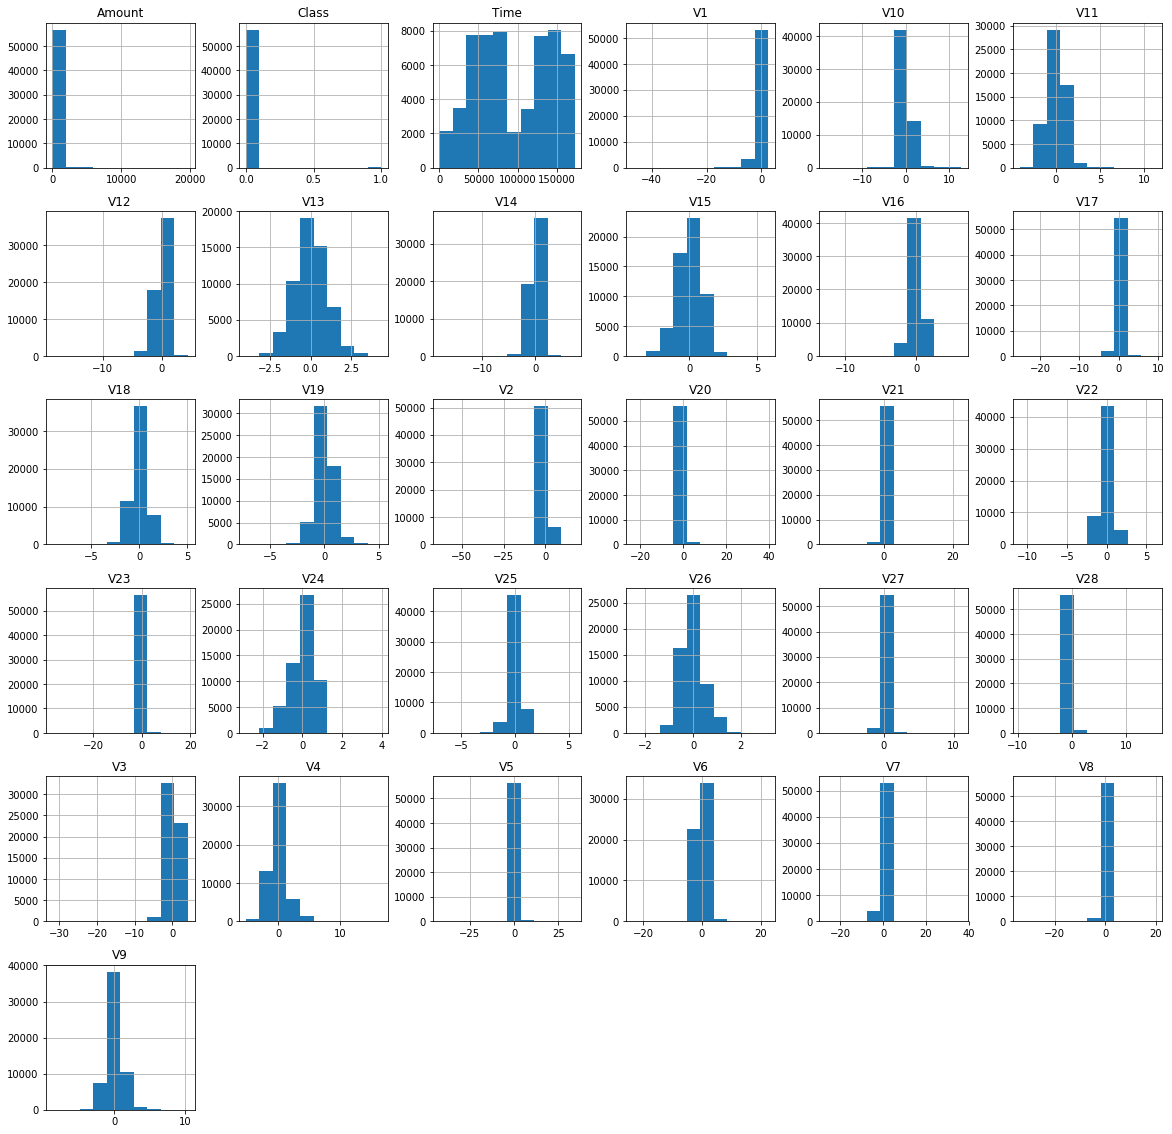

In [8]:
# plot the histogram of each parameter
data.hist(figsize = (20, 20))
plt.show()

You can see most of the V's are clustered around 0 with some or no outliers. Notice we have very few fraudulent cases over valid cases in our class histogram.

In [9]:
# determine the number of fraud cases
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.0015296972254457222
Fraud Cases: 87
Valid Cases: 56874


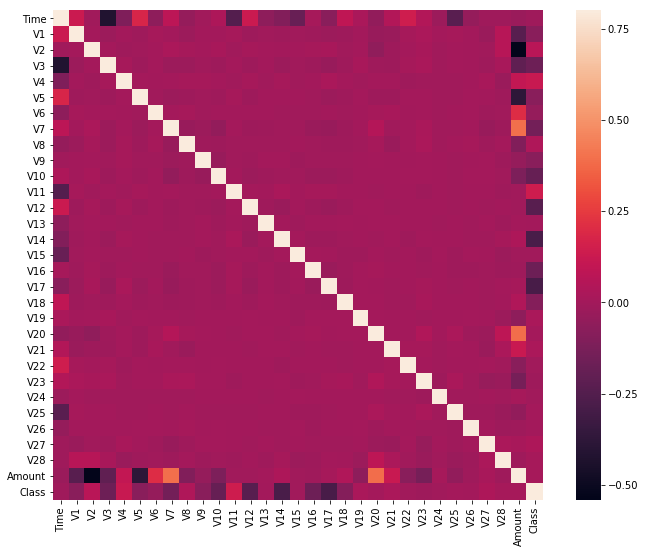

In [10]:
# correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

You can see a lot of the values are close to 0 . Most of them are fairly unrelated. The lighter squares signify a stronger correlation. 

## Organizing the Data

In [11]:
# get the columns from the dataframe
columns = data.columns.tolist()

# filter the columns to remove the data we do not want
columns = [c for c in columns if c not in ['Class']]

# store the variable we will be predicting on which is class
target = 'Class'

# X includes everything except our class column
X = data[columns]
# Y includes all the class labels for each sample
# this is also one-dimensional
Y = data[target]

# print the shapes of X and Y
print(X.shape)
print(Y.shape)

(56961, 30)
(56961,)


## Applying Algorithms

In [12]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [13]:
# define a random state
state = 1

# define the outlier detection methods
classifiers = {
    # contamination is the number of outliers we think there are
    'Isolation Forest': IsolationForest(max_samples = len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    # number of neighbors to consider, the higher the percentage of outliers the higher you want to make this number
    'Local Outlier Factor': LocalOutlierFactor(
    n_neighbors = 20,
    contamination = outlier_fraction)
}

## Fit the Model

In [14]:
import warnings  # Correctly import the warnings module
import os        # Import the os module if you need to use OS functionalities

n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    # reshape the prediction values to 0 for valid and 1 for fraud
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    # calculate the number of errors
    n_errors = (y_pred != Y).sum()
    
    # classification matrix
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 129
0.9977352925685996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.26      0.26      0.26        87

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.63      0.63      0.63     56961
weighted avg       1.00      1.00      1.00     56961

Local Outlier Factor: 173
0.9969628342199048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.01      0.01      0.01        87

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



### ROC Curve and AUC Score

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


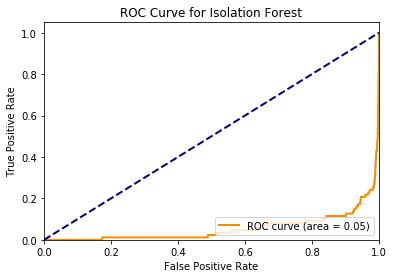

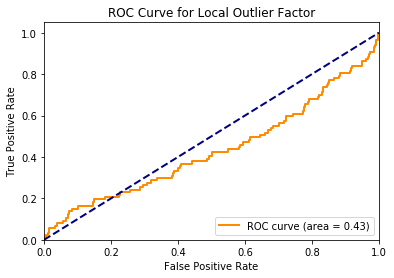

In [15]:
from sklearn.metrics import roc_curve, auc

for i, (clf_name, clf) in enumerate(classifiers.items()):
    # Fitting and prediction logic remains the same
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)

    # Reshape and calculate false positive and true positive rates
    fpr, tpr, thresholds = roc_curve(Y, scores_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {clf_name}')
    plt.legend(loc="lower right")
    plt.show()

### Cross-validation

In [16]:
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
import numpy as np

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

for clf_name, clf in classifiers.items():
    if clf_name == 'Local Outlier Factor':
        continue  # Local Outlier Factor does not have a `fit` method suitable for cross-validation
    
    # Cross-validation
    scores = cross_val_score(clf, X, Y, cv=5, scoring='accuracy')
    print(f'{clf_name} Cross-Validation Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

Isolation Forest Cross-Validation Accuracy: 0.0011 ± 0.0003


### Class Imbalance Handling

In [17]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='minority', random_state=state)
X_sm, Y_sm = smote.fit_resample(X, Y)

print(f'Before SMOTE: {Y.value_counts()}')
print(f'After SMOTE: {pd.Series(Y_sm).value_counts()}')

Using TensorFlow backend.


Before SMOTE: 0    56874
1       87
Name: Class, dtype: int64
After SMOTE: 1    56874
0    56874
dtype: int64



### Anomaly Detection using Autoencoders

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define autoencoder model
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(X.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X.shape[1], activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X, X, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

# Use the reconstruction error to detect fraud
reconstructions = autoencoder.predict(X)
reconstruction_error = np.mean(np.abs(reconstructions - X), axis=1)

# Set a threshold for outliers
threshold = np.percentile(reconstruction_error, 95)

# Predict fraud cases based on threshold
y_pred = (reconstruction_error > threshold).astype(int)
print(f'Accuracy: {accuracy_score(Y, y_pred)}')
print(classification_report(Y, y_pred))

Train on 45568 samples, validate on 11393 samples
Epoch 1/10
45568/45568 [==============================] - 3s 62us/step - loss: 373888473.1236 - val_loss: 372143852.0249
Epoch 2/10
45568/45568 [==============================] - 2s 43us/step - loss: 373887869.9101 - val_loss: 372143852.0249
Epoch 3/10
45568/45568 [==============================] - 2s 42us/step - loss: 373887869.5730 - val_loss: 372143852.0249
Epoch 4/10
45568/45568 [==============================] - 2s 44us/step - loss: 373887870.2472 - val_loss: 372143852.0249
Epoch 5/10
45568/45568 [==============================] - 2s 43us/step - loss: 373887869.7865 - val_loss: 372143852.0249
Epoch 6/10
45568/45568 [==============================] - 2s 43us/step - loss: 373887870.3708 - val_loss: 372143852.0249
Epoch 7/10
45568/45568 [==============================] - 2s 44us/step - loss: 373887869.6966 - val_loss: 372143852.0249
Epoch 8/10
45568/45568 [==============================] - 2s 44us/step - loss: 373887869.6404 - val_los

### Model Calibration

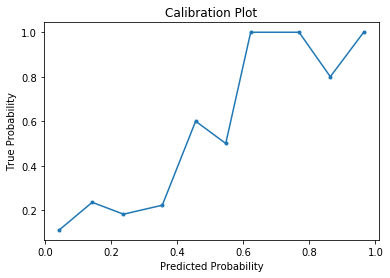

In [19]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate sample data (replace this with your actual data)
X, Y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Using RandomForest as an example
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

# Calibrate classifier using isotonic calibration
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
calibrated_clf.fit(X_train, Y_train)

# Predict probabilities on the test set
y_prob = calibrated_clf.predict_proba(X_test)[:, 1]

# Check calibration performance
prob_true, prob_pred = calibration_curve(Y_test, y_prob, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='.')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.show()

### Importing Machine Learning Models

### Logistic Regression Algorithm

Logistic Regression Accuracy: 0.9989466661985184
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.69      0.60      0.65       136

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.85      0.80      0.82     85443
weighted avg       1.00      1.00      1.00     85443



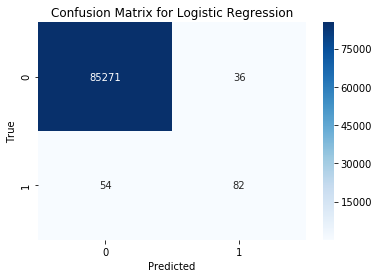

In [20]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset from the correct path
data = pd.read_csv('../input/creditcard.csv')

# Define feature matrix (X) and target variable (Y)
X = data.drop(columns=['Class'])
Y = data['Class']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize and train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, Y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(Y_test, y_pred))
print("Logistic Regression Classification Report:\n", classification_report(Y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### K-Nearest Neighbors Algorithm

KNN Accuracy: 0.9984785178423042
KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       1.00      0.04      0.08       136

   micro avg       1.00      1.00      1.00     85443
   macro avg       1.00      0.52      0.54     85443
weighted avg       1.00      1.00      1.00     85443



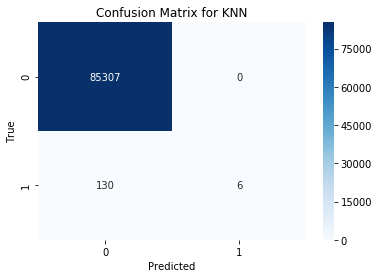

In [21]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset from the correct path
data = pd.read_csv('../input/creditcard.csv')

# Define feature matrix (X) and target variable (Y)
X = data.drop(columns=['Class'])
Y = data['Class']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize and train the model
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)

# Make predictions
y_pred = knn_clf.predict(X_test)

# Evaluate the model
print("KNN Accuracy:", accuracy_score(Y_test, y_pred))
print("KNN Classification Report:\n", classification_report(Y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###  Gradient Boosting Algorithm

Gradient Boosting Accuracy: 0.9985838512224524
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.89      0.12      0.22       136

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.95      0.56      0.61     85443
weighted avg       1.00      1.00      1.00     85443



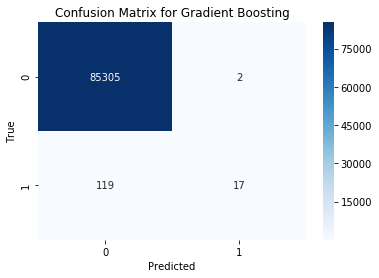

In [22]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset from the correct path
data = pd.read_csv('../input/creditcard.csv')

# Define feature matrix (X) and target variable (Y)
X = data.drop(columns=['Class'])
Y = data['Class']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize and train the model
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, Y_train)

# Make predictions
y_pred = gb_clf.predict(X_test)

# Evaluate the model
print("Gradient Boosting Accuracy:", accuracy_score(Y_test, y_pred))
print("Gradient Boosting Classification Report:\n", classification_report(Y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.89      0.12      0.22       136

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.95      0.56      0.61     85443
weighted avg       1.00      1.00      1.00     85443


KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       1.00      0.04      0.08       136

   micro avg       1.00      1.00      1.00     85443
   macro avg       1.00      0.52      0.54     85443
weighted avg       1.00      1.00      1.00     85443


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.69      0.60      0.65       136

   micro avg       1.00      1.00      1.00     85443
   macro av

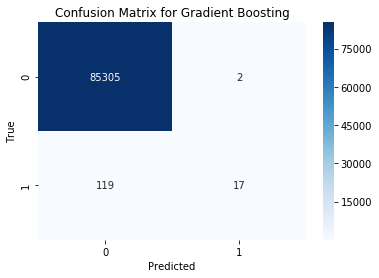


Confusion Matrix for KNN:


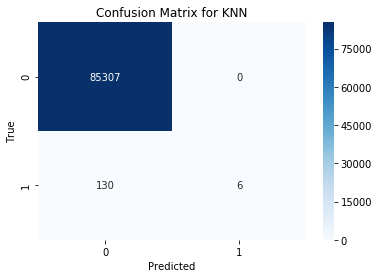


Confusion Matrix for Logistic Regression:


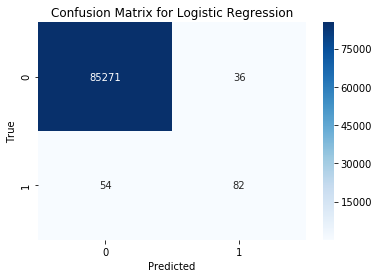

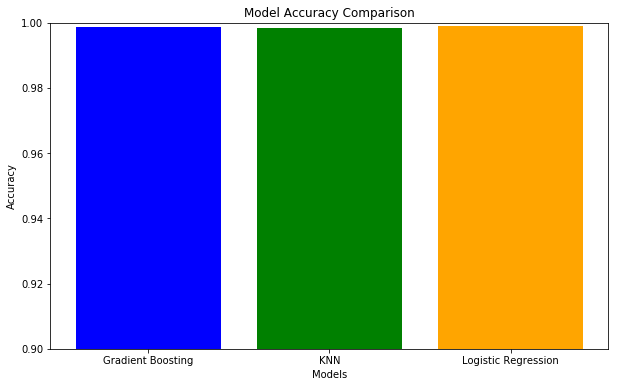

In [23]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset from the correct path
data = pd.read_csv('../input/creditcard.csv')

# Define feature matrix (X) and target variable (Y)
X = data.drop(columns=['Class'])
Y = data['Class']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Dictionary to store accuracies
accuracies = {}

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, Y_train)
y_pred_gb = gb_clf.predict(X_test)
accuracies['Gradient Boosting'] = accuracy_score(Y_test, y_pred_gb)

# K-Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)
y_pred_knn = knn_clf.predict(X_test)
accuracies['KNN'] = accuracy_score(Y_test, y_pred_knn)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, Y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracies['Logistic Regression'] = accuracy_score(Y_test, y_pred_log_reg)

# Print classification reports and confusion matrices for each model
print("\nGradient Boosting Classification Report:\n", classification_report(Y_test, y_pred_gb))
print("\nKNN Classification Report:\n", classification_report(Y_test, y_pred_knn))
print("\nLogistic Regression Classification Report:\n", classification_report(Y_test, y_pred_log_reg))

# Confusion matrices
print("\nConfusion Matrix for Gradient Boosting:")
sns.heatmap(confusion_matrix(Y_test, y_pred_gb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nConfusion Matrix for KNN:")
sns.heatmap(confusion_matrix(Y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nConfusion Matrix for Logistic Regression:")
sns.heatmap(confusion_matrix(Y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot accuracies in a bar chart to compare
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.9, 1.0)  # Adjust the y-axis to better see differences if accuracies are close
plt.show()


Looking at precision for fraudulent cases (1) lets us know the percentage of cases that are getting correctly labeled. 'Precision' accounts for false-positives. 'Recall' accounts for false-negatives. Low numbers could mean that we are constantly calling clients asking them if they actually made the transaction which could be annoying.

Goal: To get better percentages.

Our Isolation Forest method (which is Random Forest based) was able to produce a better result. Looking at the f1-score 26% (or approx. 30%) of the time we are going to detect the fraudulent transactions.